<a href="https://colab.research.google.com/github/jli5064/Projects/blob/main/outages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Power Outages
* **See the main project notebook for instructions to be sure you satisfy the rubric!**
* See Project 03 for information on the dataset.
* A few example prediction questions to pursue are listed below. However, don't limit yourself to them!
    * Predict the severity (number of customers, duration, or demand loss) of a major power outage.
    * Predict the cause of a major power outage.
    * Predict the number and/or severity of major power outages in the year 2020.
    * Predict the electricity consumption of an area.

Be careful to justify what information you would know at the "time of prediction" and train your model using only those features.

# Summary of Findings


### Introduction
The prediction problem we're attempting is to find whether the outages are caused by severe weather (natural causes) or not. This is a classification problem and the objective is to predict whether or not the outages were caused due to nature using the f1 score. 

### Baseline Model
In the baseline model, we use 2 features, U.S State and Year. U.S State is a nominal feature. Year can be thought of any of the three Ordinal, Nominal or Quantitative. However, in this case we use Year as another nominal feature. We use f1 score as our evalutaion metric, as aim to achieve as low false positives and low false negatives as we can. We think it's a pretty good evaluation metric or accuracy estimator in this case as it coveys the balance between the precision and the recall. 

### Final Model
In the Final Model we create two new features by trasnforming two columns are performing one-hot encoding on them. The columns we transformed are CAUSE.CATEGORY.DETAIL and HURRICANE.NAMES. Both of these have direct correlation with our prediction problem. Hurricane data will be empty in case there was no hurricane and filled in case there was a hurricane. Hurricanes are a natural cause helping us with our prediction problem. CAUSE.CATEGORY.DETAIL on the other hand will give us deep insight into exactly what the cause of the outage is, whether is something cause naturally or maybe just a technical issue or a grid failure. The model we type we chose was DecisionTreeClassifier(). This being a classification problem, DecisionTreeClassifier would fit just perfect with it coupled with one hot encoding. We used a GridSearchCV to iterate over multiple models and parameters and found that DecisionTreeClassifier() was the best model using max_depth = 11, min_samples_leaf = 2 and min_samples_split = 7. 

### Fairness Evaluation
In this part, we are determining whether our model is fair or not, specifically on when the "CLIMATE CATEGORY" column is "cold" vs when it is NOT "cold". We binarized and created a column that is 1 when the category is cold and 0 when the category is not cold. 

For the parity measure, we have chose to use the accuracy score to examine the fairness of our model.

The next step is to perform a permutation test.

Our null hypothesis is that our model is fair, the accuracy score are roughly the same for both subsets.

Our alternative hypothesis is that our model is unfair, the model perform better when it is "cold".

Upon doing a permutation test, we got a p value of 0.0105, using a 1% significance level, we fail to reject the null hypothesis suggesting that our model was fair.

# Code

In [ ]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from google.colab import files
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from pandas.core.common import SettingWithCopyWarning

In [ ]:
files.upload()

Saving outage.xlsx to outage (2).xlsx


{'outage.xlsx': b'PK\x03\x04\x14\x00\x06\x00\x08\x00\x00\x00!\x00\x03p\xe2\xba\x96\x01\x00\x00W\x06\x00\x00\x13\x00\x08\x02[Content_Types].xml \xa2\x04\x02(\xa0\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00

In [ ]:
#Cleaning data to make it more readable

df = pd.read_excel("outage.xlsx")
df.columns = list(df.loc[4])
df = df.drop('variables', axis = 1).drop([0,1,2,3,4,5]).drop('OBS', axis = 1).reset_index().drop('index', axis = 1)

In [ ]:
df.head(5)

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,OUTAGE.RESTORATION.DATE,OUTAGE.RESTORATION.TIME,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,HURRICANE.NAMES,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,RES.PRICE,COM.PRICE,IND.PRICE,TOTAL.PRICE,RES.SALES,COM.SALES,IND.SALES,TOTAL.SALES,RES.PERCEN,COM.PERCEN,IND.PERCEN,RES.CUSTOMERS,COM.CUSTOMERS,IND.CUSTOMERS,TOTAL.CUSTOMERS,RES.CUST.PCT,COM.CUST.PCT,IND.CUST.PCT,PC.REALGSP.STATE,PC.REALGSP.USA,PC.REALGSP.REL,PC.REALGSP.CHANGE,UTIL.REALGSP,TOTAL.REALGSP,UTIL.CONTRI,PI.UTIL.OFUSA,POPULATION,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
0,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01 00:00:00,17:00:00,2011-07-03 00:00:00,20:00:00,severe weather,NaN,NaN,3060,NaN,70000,11.6,9.18,6.81,9.28,2332915,2114774,2113291,6562520,35.5491,32.225,32.2024,2308736,276286,10673,2595696,88.9448,10.644,0.411181,51268,47586,1.07738,1.6,4802,274182,1.75139,2.2,5348119,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
1,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11 00:00:00,18:38:00,2014-05-11 00:00:00,18:39:00,intentional attack,vandalism,NaN,1,NaN,NaN,12.12,9.71,6.49,9.28,1586986,1807756,1887927,5284231,30.0325,34.2104,35.7276,2345860,284978,9898,2640737,88.8335,10.7916,0.37482,53499,49091,1.08979,1.9,5226,291955,1.79,2.2,5457125,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
2,2010,10,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26 00:00:00,20:00:00,2010-10-28 00:00:00,22:00:00,severe weather,heavy wind,NaN,3000,NaN,70000,10.87,8.19,6.07,8.15,1467293,1801683,1951295,5222116,28.0977,34.501,37.366,2300291,276463,10150,2586905,88.9206,10.687,0.392361,50447,47287,1.06683,2.7,4571,267895,1.70627,2.1,5310903,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
3,2012,6,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19 00:00:00,04:30:00,2012-06-20 00:00:00,23:00:00,severe weather,thunderstorm,NaN,2550,NaN,68200,11.79,9.25,6.71,9.19,1851519,1941174,1993026,5787064,31.9941,33.5433,34.4393,2317336,278466,11010,2606813,88.8954,10.6822,0.422355,51598,48156,1.07148,0.6,5364,277627,1.93209,2.2,5380443,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
4,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18 00:00:00,02:00:00,2015-07-19 00:00:00,07:00:00,severe weather,NaN,NaN,1740,250,250000,13.07,10.16,7.74,10.43,2028875,2161612,1777937,5970339,33.9826,36.2059,29.7795,2374674,289044,9812,2673531,88.8216,10.8113,0.367005,54431,49844,1.09203,1.7,4873,292023,1.6687,2.2,5489594,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874


In [ ]:
# Creating a new binary column that contains value 0 and 1. 
# 1 if the outage was cuased by severe weather and 0 if the outage was not caused by severe weather. 
# This is the column that we're going to predicting

df['WEATHER.BINARIZER'] = df['CAUSE.CATEGORY'].apply(lambda x: 1 if x=='severe weather' else 0)

### Baseline Model

In [ ]:
#One-Hot encoding two columns: U.S._STATE and YEAR. Then putting them in a column trasnformer and then a pipeline.
#Using DecsisionTreeClassifier as the final step in the baseline model.

name = ['U.S._STATE', 'YEAR']
name_transformer = Pipeline(steps=[('onehot', OneHotEncoder())])

preproc = ColumnTransformer(transformers=[('name', name_transformer, name)])

pl = Pipeline(steps=[('preprocessor', preproc), ('regressor', DecisionTreeClassifier())])

In [ ]:
#Initialising the X and y values. The dataset without the target column and the traget column respectively.
X, y = df.drop(['WEATHER.BINARIZER'], 1), df['WEATHER.BINARIZER']

#Splitting the X,y value in train and test datasets. Then fitting it, predicting the values and calculating the f1 score.
#Calculating the f1 score a 1000 times and then finding the mean of all the scores to get a more accurate value. 
lst = []
for i in range(1000):
  try:
    x_train, x_test, y_train, y_test = train_test_split(X, y)
    pl.fit(x_train, y_train)
    pred = pl.predict(x_test)
    base_precision = metrics.precision_score(y_test, pred)
    base_recall = metrics.recall_score(y_test, pred)
    lst.append(2*(base_precision * base_recall) / (base_precision + base_recall))
  except ValueError:
      pass   
np.mean(lst) 

0.7142506612663687

### Final Model

In [ ]:
#Initialising a list of all values in the CAUSE.CATEGORY.DETAIL column which could fall under natural cuases

ex = ['heavy wind', 'thunderstorm', 'winter storm', 'tornadoes',
       'hailstorm', 'winter', 'wind storm', 'storm', 'hurricanes',
       'wind/rain', 'snow/ice storm', 'snow/ice ', 'flooding',
       'lightning', 'wildfire', 'heatwave', 'wind', 'uncontrolled loss',
       'fog', 'earthquake', 'public appeal', 'thunderstorm; islanding']

In [ ]:
#Initialising parameters for DecisionTreeClassifier for GridSearchCv to loop through all of these parameters.

parameters = {
    'max_depth': list(range(10,21)), 
    'min_samples_split':[2,3,5,7,10,15,20,25,30],
    'min_samples_leaf':[2,3,5,7,10,15,20,25,30]
}

In [ ]:
#This is NOT the final model
#In this block we create a muted version ofthe enhanced pipeline using GridSearchCV to find the best combination of parameters

#Creating feature 1
#Transforming HURRICANE.NAMES column using function trasnformer for binarizing the column and then one-hot encoding it in a pipeline
name = ['HURRICANE.NAMES']
def func(a):
      return a['HURRICANE.NAMES'].apply(lambda x: 1 if type(x) == str else 0).to_frame()
transformer = FunctionTransformer(func, validate = False)
name_transformer = Pipeline(steps=[('name', transformer), ('onehot', OneHotEncoder())])

#Creating feature 2
#Transforming CAUSE.CATEGORY.DETAIL column using function trasnformer for binarizing the column and then one-hot encoding it in a pipeline
f = ['CAUSE.CATEGORY.DETAIL']
def func_2(a):
      return a['CAUSE.CATEGORY.DETAIL'].apply(lambda x: 1 if x in ex else 0).to_frame()
transformer_2 = FunctionTransformer(func_2, validate = False)
f_transformer = Pipeline(steps=[('name', transformer_2), ('onehot', OneHotEncoder())])

#Taken from the baseline model
oh = ['U.S._STATE', 'YEAR']
oh_transformer = Pipeline(steps=[('onehot', OneHotEncoder())])

preproc = ColumnTransformer(transformers=[('name', name_transformer, name), ('f', f_transformer, f), ('oh', oh_transformer, oh)])

#Using GridSearchCV here to find the best combination of parameters
pl = Pipeline(steps=[('preprocessor', preproc), ('classifier', GridSearchCV(DecisionTreeClassifier(), parameters))])

In [ ]:
#Initialising the X and y values. The dataset without the target column and the traget column respectively.
X, y = df.drop(['WEATHER.BINARIZER'], 1), df['WEATHER.BINARIZER']

#Splitting the X,y values into train and test datasets and then fitting it 
x_train, x_test, y_train, y_test = train_test_split(X, y)
pl.fit(x_train, y_train)

#Here we initialise best_classifier variable with a DecisionTreeClassifer() with the best parameters
best_classifier = pl[-1].best_estimator_

In [ ]:
best_classifier

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=11, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
#This is the FINAL model using the best DecisionTreeClassifer obtained from GridSearchCV

#Creating feature 1
#Transforming HURRICANE.NAMES column using function trasnformer for binarizing the column and then one-hot encoding it in a pipeline
name = ['HURRICANE.NAMES']
def func(a):
      return a['HURRICANE.NAMES'].apply(lambda x: 1 if type(x) == str else 0).to_frame()
transformer = FunctionTransformer(func, validate = False)
name_transformer = Pipeline(steps=[('name', transformer), ('onehot', OneHotEncoder())])

#Creating feature 2
#Transforming CAUSE.CATEGORY.DETAIL column using function trasnformer for binarizing the column and then one-hot encoding it in a pipeline
f = ['CAUSE.CATEGORY.DETAIL']
def func_2(a):
      return a['CAUSE.CATEGORY.DETAIL'].apply(lambda x: 1 if x in ex else 0).to_frame()
transformer_2 = FunctionTransformer(func_2, validate = False)
f_transformer = Pipeline(steps=[('name', transformer_2), ('onehot', OneHotEncoder())])

#Taken from the baseline model
oh = ['U.S._STATE', 'YEAR']
oh_transformer = Pipeline(steps=[('onehot', OneHotEncoder())])

preproc = ColumnTransformer(transformers=[('name', name_transformer, name), ('f', f_transformer, f), ('oh', oh_transformer, oh)])

#Using the best DecisionTreeClassifier in the final model
pl = Pipeline(steps=[('preprocessor', preproc), ('classifier', best_classifier)])

In [ ]:
#Initialising the X and y values. The dataset without the target column and the traget column respectively.
X, y = df.drop(['WEATHER.BINARIZER'], 1), df['WEATHER.BINARIZER']

#Splitting the X,y value in train and test datasets. Then fitting it, predicting the values and calculating the f1 score.
#Calculating the f1 score a 1000 times and then finding the mean of all the scores to get a more accurate value. 
lst = []
for i in range(1000):
  try:
    x_train, x_test, y_train, y_test = train_test_split(X, y)
    pl.fit(x_train, y_train)
    pred = pl.predict(x_test)
    base_precision = metrics.precision_score(y_test, pred)
    base_recall = metrics.recall_score(y_test, pred)
    lst.append(2*(base_precision * base_recall) / (base_precision + base_recall))
  except ValueError:
      pass   
np.mean(lst) 

0.881729516373345

As you can see in the above final model that the mean f1 score from 1000 iterations is 0.881729516373345 which is a significant improvement from the mean f1 score of the baseline model which was 0.7142506612663687 which was a result of the addition of the two new features.

### Fairness Evaluation

In [ ]:
# create a "IS_COLD" column so it is easier to distinguish cold vs non=cold climate
df['IS_COLD'] = df['CLIMATE.CATEGORY'].apply(lambda x: 1 if x == "cold" else 0)
df.head(5)

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,OUTAGE.RESTORATION.DATE,OUTAGE.RESTORATION.TIME,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,HURRICANE.NAMES,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,RES.PRICE,COM.PRICE,IND.PRICE,TOTAL.PRICE,RES.SALES,COM.SALES,IND.SALES,TOTAL.SALES,RES.PERCEN,COM.PERCEN,IND.PERCEN,RES.CUSTOMERS,COM.CUSTOMERS,IND.CUSTOMERS,TOTAL.CUSTOMERS,RES.CUST.PCT,COM.CUST.PCT,IND.CUST.PCT,PC.REALGSP.STATE,PC.REALGSP.USA,PC.REALGSP.REL,PC.REALGSP.CHANGE,UTIL.REALGSP,TOTAL.REALGSP,UTIL.CONTRI,PI.UTIL.OFUSA,POPULATION,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,WEATHER.BINARIZER,IS_COLD
0,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01 00:00:00,17:00:00,2011-07-03 00:00:00,20:00:00,severe weather,NaN,NaN,3060,NaN,70000,11.6,9.18,6.81,9.28,2332915,2114774,2113291,6562520,35.5491,32.225,32.2024,2308736,276286,10673,2595696,88.9448,10.644,0.411181,51268,47586,1.07738,1.6,4802,274182,1.75139,2.2,5348119,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874,1,0
1,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11 00:00:00,18:38:00,2014-05-11 00:00:00,18:39:00,intentional attack,vandalism,NaN,1,NaN,NaN,12.12,9.71,6.49,9.28,1586986,1807756,1887927,5284231,30.0325,34.2104,35.7276,2345860,284978,9898,2640737,88.8335,10.7916,0.37482,53499,49091,1.08979,1.9,5226,291955,1.79,2.2,5457125,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874,0,0
2,2010,10,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26 00:00:00,20:00:00,2010-10-28 00:00:00,22:00:00,severe weather,heavy wind,NaN,3000,NaN,70000,10.87,8.19,6.07,8.15,1467293,1801683,1951295,5222116,28.0977,34.501,37.366,2300291,276463,10150,2586905,88.9206,10.687,0.392361,50447,47287,1.06683,2.7,4571,267895,1.70627,2.1,5310903,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874,1,1
3,2012,6,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19 00:00:00,04:30:00,2012-06-20 00:00:00,23:00:00,severe weather,thunderstorm,NaN,2550,NaN,68200,11.79,9.25,6.71,9.19,1851519,1941174,1993026,5787064,31.9941,33.5433,34.4393,2317336,278466,11010,2606813,88.8954,10.6822,0.422355,51598,48156,1.07148,0.6,5364,277627,1.93209,2.2,5380443,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874,1,0
4,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18 00:00:00,02:00:00,2015-07-19 00:00:00,07:00:00,severe weather,NaN,NaN,1740,250,250000,13.07,10.16,7.74,10.43,2028875,2161612,1777937,5970339,33.9826,36.2059,29.7795,2374674,289044,9812,2673531,88.8216,10.8113,0.367005,54431,49844,1.09203,1.7,4873,292023,1.6687,2.2,5489594,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874,1,0


In [ ]:
# create a training and testing set of the data 
X, y = df.drop(['IS_COLD'], 1), df['IS_COLD']
x_train, x_test, y_train, y_test = train_test_split(X, y)
# fit the final model to the training data
pl.fit(x_train, y_train)
# make a prediction on the test data
final_prediction = pl.predict(x_test)

In [ ]:
# add a prediction, actual, and original IS_COLD column to the test dataset
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
x_test['prediction'] = final_prediction
x_test['actual'] = y_test
x_test['IS_COLD'] = y_test

In [ ]:
# create a dataframe to see the accuracy of the model when IS_COLD = true vs IS_COLD = false
(
    x_test.
    groupby('IS_COLD').
    apply(lambda x: metrics.accuracy_score(x.actual, x.prediction)).
    rename('accuracy').
    to_frame()
)

,accuracy
IS_COLD,
0,0.879699
1,0.635593


In [ ]:
# this is the observed difference of accuracy score when IS_COLD = true vs IS_COLD = false. Since the differences is negative suggesting accuracy is lower
# when weather is cold
obs = x_test.groupby('IS_COLD').apply(lambda x: metrics.accuracy_score(x.prediction, x.actual)).diff().iloc[-1]
obs

-0.24410602778131774

In [ ]:
# here we will perform a permutation test 10000 times, by shuffling the IS_COLD column
# and calculate the accuracy score of each permutation and append it to a list
lst = []
for _ in range(10000):
  s = (x_test[['IS_COLD','prediction', 'actual']]
       .assign(IS_COLD=x_test['IS_COLD'].sample(frac=1, replace=False).reset_index(drop = True))
       .groupby('IS_COLD')
       .apply(lambda x: metrics.accuracy_score(x.prediction, x.actual))
       .diff()
       .iloc[-1])
  lst.append(s)

0.0105


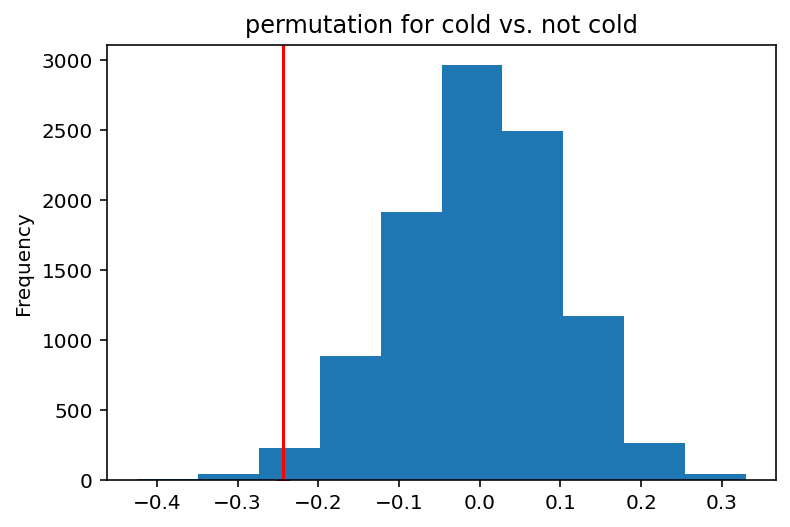

In [ ]:
#Here we find out the p value.
#We also plot a histogram with all the accuracies calculated in the previous lst and the red line indictes the observed value.

print(pd.Series(lst <= obs).mean())
pd.Series(lst).plot(kind='hist', title = "permutation for cold vs. not cold")
plt.scatter(obs, 0, c = 'r')
plt.axvline(obs, color = 'red')

Here we fail to reject the null hypothesis using a significance level of 1% since our p value is 0.0105, which is greater than 0.01.
